# Problem Set 5, due June 1 at 11:59 pm.

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [5]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [6]:
# enter your code below

print "Number of reviews: %i" % len(reviews)

Number of reviews: 13419


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

In [16]:
# enter your code here

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [17]:
# enter your code here

### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

In [18]:
# enter your code here

*enter your observations here*

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

Original text is
machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
[[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
[u'learning', u'machine', u'rocks', u'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [11]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    #Your code here    
    return X, Y


In [ ]:
X, Y = make_xy(reviews)

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [ ]:
# enter your code here

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [ ]:
# enter your code here

# call the fitted model fitted_model, for future reference:
fitted_model = # your code here

*enter your observations here*

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [ ]:
# Your code here

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [ ]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, xtest, ytest)

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [ ]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        #your code here

### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [21]:
#Enter your code here

*enter your observations here*

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [4]:
#Enter your code here

*enter your observations here*

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [22]:
# Enter your code here

*enter your observations here*

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [ ]:
#Your code here

*Enter your observations here*

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [2]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

In [ ]:
# Enter your code here

### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

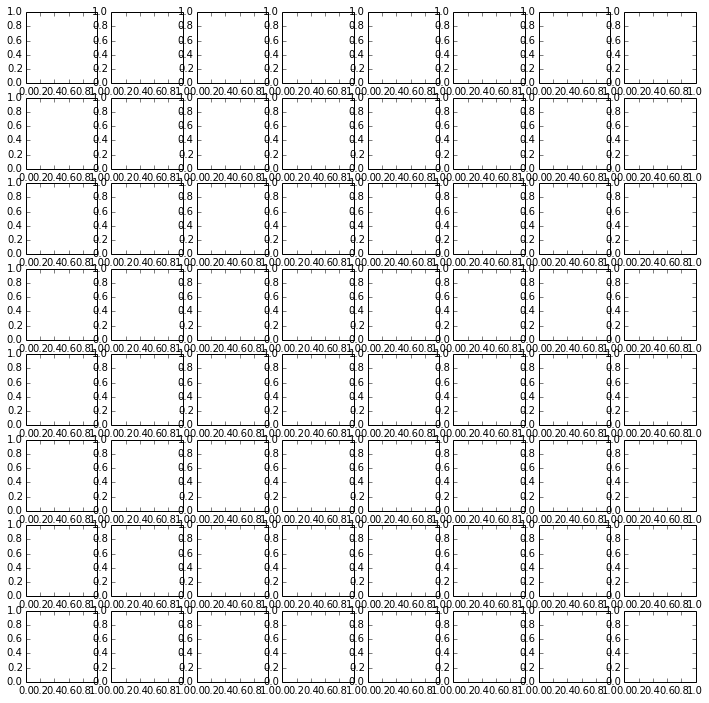

In [34]:
plt.figure(figsize=(12,12))
for i in xrange(8):
    for j in xrange(8):
        plt.subplot(8, 8, i * 8 + j + 1)
        # insert your code here

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

In [34]:
# Enter your code here

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

In [34]:
# Enter your code here

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

*Enter your observations here*